In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torch
import os

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize, transforms
from torch.utils.data import DataLoader
from torch.functional import F

import matplotlib.pyplot as plt


In [2]:
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
data_loc = 'traffic_data'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,244)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ConvertImageDtype(torch.float32)
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ConvertImageDtype(torch.float32)
    ]),
}
img_dir = data_loc
test_csv = data_loc+"/Test.csv"
test_data = GTSRB(img_dir = img_dir, annotations_file = test_csv,
                  transform = data_transforms["test"])

train_csv = data_loc+"/Train.csv"
train_data = GTSRB(img_dir = img_dir, annotations_file = train_csv,
                  transform = data_transforms["train"])

#print(test_dataloader)
train_data_path = data_loc+"/Train"



dataset = {
    "train" : torchvision.datasets.ImageFolder(root = train_data_path, transform =data_transforms["train"]),
    
    #"test" : torchvision.datasets.ImageFolder(root = test_data_path, transform =data_transforms["test"])
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_loader ={
    "train" : DataLoader(train_data, batch_size=32, shuffle=True),
    
    "test" : DataLoader(test_data, batch_size=32, shuffle=True)
}
#print(len(dataset_loader["test"].dataset), len(dataset_loader["train"].dataset))

{'train': 39209, 'test': 12630}
Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


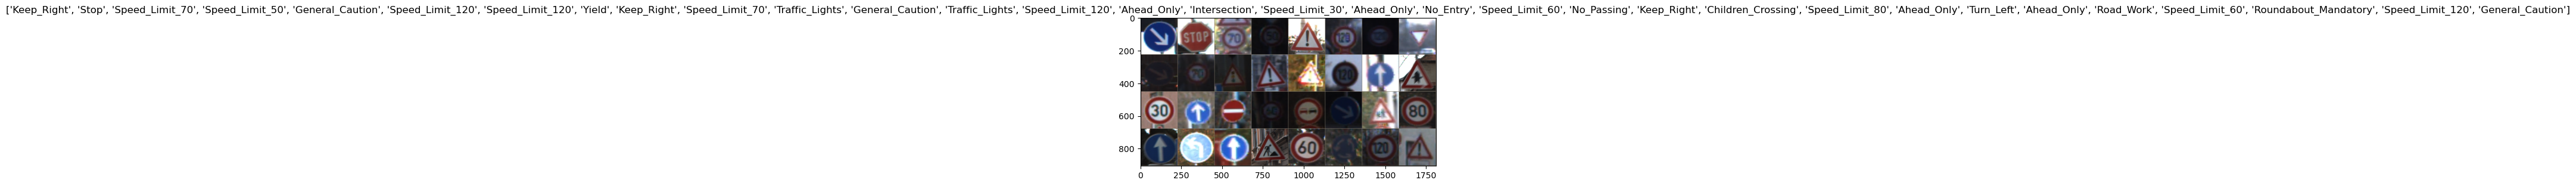

In [4]:
class_ids = ["Speed_Limit_20","Speed_Limit_30","Speed_Limit_50","Speed_Limit_60", "Speed_Limit_70", "Speed_Limit_80",
            "End_Speed_Limit_80","Speed_Limit_100","Speed_Limit_120","No_Passing","No_Passing_Over_3.5m","Intersection",
            "Priority_Road","Yield","Stop","No_Vehicles","Vehicles_over_3.5_prohibited","No_Entry","General_Caution",
            "Curve_Left","Curve_Right","Double_Curve","Bumpy_Road", "Slippery_road","Narrowroad_Right","Road_Work","Traffic_Lights",
            "Pedestrains","Children_Crossing","Bicycles_Crossing","Beware_Ice_and_Snow","Animals_Crossing","End_of_all_speed_limits",
            "Turn_Right","Turn_Left","Ahead_Only","Go_Straight_Right","Go_Straight_Left","Keep_Right","Keep_Left","Roundabout_Mandatory",
            "End_no_passing","End_no_passing_over_3.5"]

class_names={int(x) : class_ids[int(x)] for x in os.listdir(train_data_path)}

#print(class_names)

dataset_sizes = {'train' : len(dataset_loader["train"].dataset), 'test': len(dataset_loader["test"].dataset)}
print(dataset_sizes)

train_features, train_labels = next(iter(dataset_loader["train"]))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataset_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "Models/best_model")
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader['test']):
            inputs, labels =  inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [7]:
def score_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    correct =0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                if class_names[preds[j].item()] == class_names[labels[j].item()]:
                    correct += 1 
                    
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    print("Accuracy: ",correct/num_images)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.wide_resnet50_2(pretrained=True)
#wideresnet.eval()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 43)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/lunet/cota7/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lunet/cota7/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 10.76 GiB total capacity; 9.46 GiB already allocated; 39.00 MiB free; 9.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

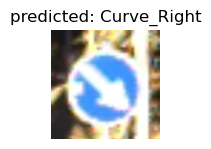

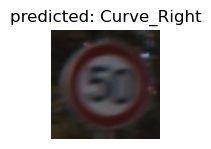

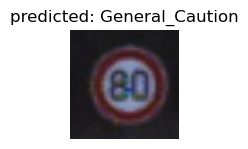

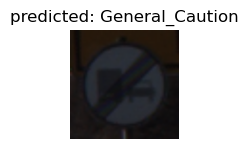

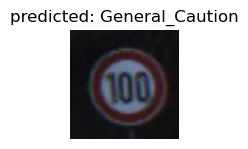

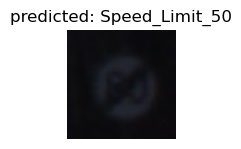

In [ ]:
visualize_model(model_ft)

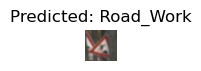

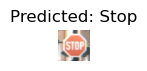

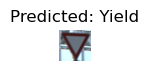

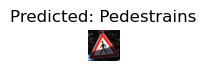

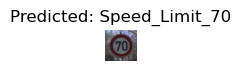

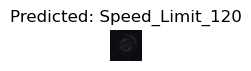

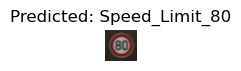

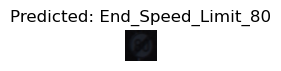

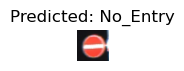

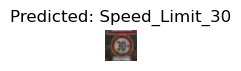

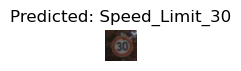

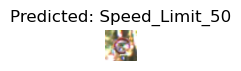

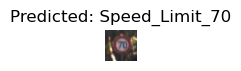

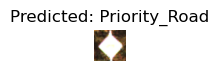

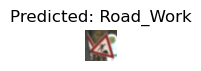

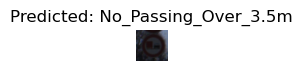

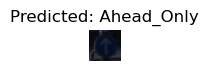

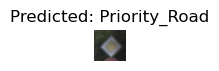

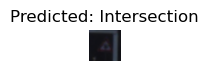

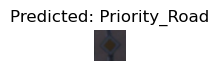

In [9]:
#using traffic sign trained best model
model_ft.load_state_dict(torch.load("Models/best_model"))
visualize_model(model_ft, num_images=20)

In [10]:
#results from transfer learning
score_model(model_ft, 500)

Accuracy:  0.988


In [11]:
#next look at FGSM

#perturbed_image=image+epsilon∗sign(data_grad)=x+ϵ∗sign(∇xJ(θ,x,y))
def fgsm_atk(img, epsilon, data_grad):
    #get sign of the data's gradient
    sign_data_grad = data_grad.sign()

    #create the perturbed image by adjusting each pixel of the input image
    perturbed_image = img +epsilon*sign_data_grad

    #add clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0,1)

    #Return the perturbed image
    return perturbed_image

In [12]:
def test(model, epsilon, num_images=6):

    # Accuracy counter
    correct = 0
    adv_examples = []
    images_so_far=0
    # Loop over all examples in test set
    for i, (data, target) in enumerate(dataset_loader['test']):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        for i in range(len(init_pred)):
            if init_pred[i].item() != target[i].item():
                continue
            
            if images_so_far >= num_images*32:
                break
            print(images_so_far)
            images_so_far+=1

            # Calculate the loss
            loss = F.nll_loss(output, target)

            # Zero all existing gradients
            model.zero_grad()

            # Calculate gradients of model in backward pass
            loss.backward()

            # Collect datagrad
            data_grad = data.grad.data

            # Call FGSM Attack
            perturbed_data = fgsm_atk(data, epsilon, data_grad)

            # Re-classify the perturbed image
            output = model(perturbed_data)

            # Check for success
            final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            
            if final_pred[i].item() == target[i].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )
        if images_so_far > num_images*32:
                break
 
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(images_so_far)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, images_so_far, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [13]:
accuracies = []
examples = []
epsilons=[0,0.05,0.1]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model_ft, eps,3)
    accuracies.append(acc)
    examples.append(ex)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95


KeyboardInterrupt: 